<a href="https://colab.research.google.com/github/kdjoumessi/ML4ThPh/blob/main/Makerere_ML4ThPh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML4ThPh Project: MakerereMakerere Fall Armyworm Crop
## by DJOUMESSI Kerol

## 1. Problem description
 Fall armyworm is a devastating pest that affects many crops like maize, rice across sub-Sahara and Asia [1, 2]. Indeed, there are no natural predators for fall armyworms and it causes majors devasting effects on maize production leading to average maize losses of 31% annually [2]. Since maize is one of the most widely grown crops in Africa, it occupies more than 24% of farmland making it one of the most food since over 300 million Africans depend on it [2].

To ensure and maintain food security, farmers must fight against the fall armyworm in order to improve their harvest and meet the needs of the population otherwise this pest could affect maize production and lead to food insecurity which as result will contribute to increase the poverty in Africa. In general, one way to fight against this pest is to kill them by applying insecticides on crops affected. therefore, it can be difficult for humans to monitor large plantations in order to design early intervention mechanisms. However, the great success of computer vision these days could offer a way to build smart systems to prevent crop loss by helping farmers fight the Fall Armyworm.

The goal of this project is to help farmers classify if a plant has been affected by FAW, as this will lead to the design early intervention. This is a binary image classification task.

### Evaluation
The evaluation metric for this classification task is the **Area Under the Curve (AUC)**. Indeed, AUC is a classification metrics that measure the degree of separability between classes. The higher AUC, the better the model is good at truly separate classes [3]


### Dataset description
The raw dataset contains images of maize crop leaves collected by research scientists from the Makerere Artificial Intelligence Lab, the Marconi Machine Learning Lab, and the National Crops Research Institute in Uganda. It contains `1619` images equally distributed across the healthy and fall armyworm classes.

[1] https://www.sciencedirect.com/science/article/pii/S004896972033535X <br>
[2] https://zindi.africa/competitions/makerere-fall-armyworm-crop-challenge <br>
[3] https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5 <br>

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import pandas as pd
import numpy as np

import cv2
import skimage

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import time
import yaml
from munch import munchify
from datetime import datetime
from collections import OrderedDict

from torch.utils.data import DataLoader
from torchvision import transforms, models

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tools.data import dataset
from tools.func import *

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
#!pip install grad-cam

In [ ]:
SEED = 819

## 2. Dataset overview: Explanatory data analysis
The dataset used for this task consists of one csv file containing 3 columns:
- `Image_id`: image identifier, mapping to .JPG image files located in a folder.
- `Label`: target value

In [ ]:
dir = 'Makerere_Fall_Armyworm_Crop_Challenge/data'
data = pd.read_csv(os.path.join(dir, 'Train.csv'))
test = pd.read_csv(os.path.join(dir,'Test.csv'))
submit = pd.read_csv(os.path.join(dir,'SampleSubmission.csv'))

In [ ]:
print('dataset len', len(data))
print('shape', data.shape)
print('proportion \n', data.Label.value_counts())

dataset len 1619
shape (1619, 2)
proportion 
 0    810
1    809
Name: Label, dtype: int64


In [ ]:
# visualize the first 5 rows
data.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [ ]:
#test.head(3)

In [ ]:
#submit.head(3)

In [ ]:
#test.shape, submit.shape

### Statistics over the dataset
#### How many data of each class?

In [ ]:
# unique target
data.Label.unique()

array([1, 0])

In [ ]:
# get the number of class
data.Label.nunique()

2

In [ ]:
# class proportions
print('class proportions')
(data.Label.value_counts() / len(data)) * 100

class proportions


0    50.030883
1    49.969117
Name: Label, dtype: float64

The mean number of training images per crops is 809.5, and the median is 809.


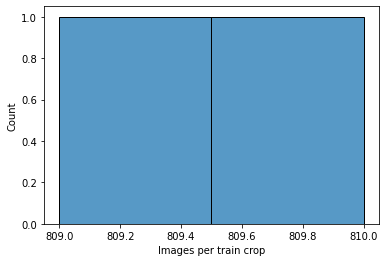

In [ ]:
train_images_count = pd.value_counts(data['Label'])
print('The mean number of training images per crops is '
      f'{round(np.mean(train_images_count), 2)}, '
      f'and the mediaelse:
                label = self.labels.iloc[index]n is {int(np.median(train_images_count))}.')
sns.histplot(train_images_count)
plt.xlabel('Images per train crop')
plt.show()

else:
                label = self.labels.iloc[index]
### Plot the number of image per class
- easily see the class repartition
- balanced or inbalanced dataset

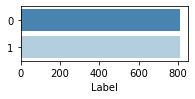

In [ ]:
data_images_per_crop = pd.value_counts(data['Label'])
plt.figure(figsize=(3, 1))
sns.barplot(x=data_images_per_crop, y=data_images_per_crop.index,
            palette='Blues_r', orient='horizontal')
plt.show()

### Train, validation, test split (75, 10, 15)
Dataset + Dataloader
- [How to Split a Dataframe into Train and Test Set with Python](https://towardsdatascience.com/how-to-split-a-dataframe-into-train-and-test-set-with-python-eaa1630ca7b3)

In [ ]:
train, validation = train_test_split(data,
                              test_size=0.25,
                              random_state=42,
                              shuffle=True,
                             )

val, test = train_test_split(validation,
                              test_size=0.6,
                              random_state=42,
                              shuffle=True,
                             )

train_csv = os.path.join(dir, 'custom_train.csv')
val_csv = os.path.join(dir, 'custom_val.csv')
test_csv = os.path.join(dir, 'custom_test.csv')

# write train and val labels to experiment folder
train.to_csv(train_csv, index=False) # columns=['image', 'level']
val.to_csv(val_csv, index=False)
test.to_csv(test_csv, index=False)

In [ ]:
train.shape, val.shape, test.shape

((1214, 2), (162, 2), (243, 2))

In [ ]:
# training dataset proportion
print(len(train))
train.Label.value_counts() / len(train)

1214


1    0.510708
0    0.489292
Name: Label, dtype: float64

In [ ]:
# validation dataset proportion
print(len(val))
val.Label.value_counts() / len(val)

162


0    0.561728
1    0.438272
Name: Label, dtype: float64

In [ ]:
# test dataset proportion
print(len(test))
test.Label.value_counts() / len(test)

243


0    0.514403
1    0.485597
Name: Label, dtype: float64

### Loading the config file

In [ ]:
## config file
config_file = 'Makerere_Fall_Armyworm_Crop_Challenge/configs.yaml'
with open(config_file) as fhandle:
    cfg = yaml.safe_load(fhandle)

cfg = munchify(cfg)

### Data preprocessing (Transformation), and dataset  

In [ ]:
IMG_SIZE = [224, 224]

val_transform = transforms.Compose([transforms.ToPILImage(),
                         transforms.Resize(IMG_SIZE),
                         transforms.ToTensor(),
                        ])

train_transform = transforms.Compose([transforms.ToPILImage(),
                         transforms.Resize(IMG_SIZE),
                         transforms.RandomApply([
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomVerticalFlip()], p=0.9),
                         transforms.ToTensor(),
                        ])

In [ ]:
BATCH_SIZE = 8

train_dataset = dataset.MakerereDataset(cfg, transform=train_transform, dtype='train', full_ds=False)
val_dataset = dataset.MakerereDataset(cfg, transform=val_transform, dtype='val')
test_dataset = dataset.MakerereDataset(cfg, transform=val_transform, dtype='test', full_ds=False)

print('training dataset size: ', len(train_dataset))
print('validation dataset size: ', len(val_dataset))
print('test dataset size: ', len(test_dataset))
print()

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          num_workers=2,
                          pin_memory=False,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          num_workers=2,
                          pin_memory=False,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=False,
                          num_workers=2,
                          pin_memory=False,
                          shuffle=False)

print('training dataset loader size: ', len(train_loader))
print('validation dataset loader size: ', len(val_loader))
print('test dataset loader size: ', len(test_loader))
print()

print(len(train_loader), len(val_loader))

training dataset size:  1214
validation dataset size:  162
test dataset size:  243

training dataset loader size:  151
validation dataset loader size:  20
test dataset loader size:  31

151 20


### Data visualization
We display some training data with the corresponding class

torch.Size([16, 3, 224, 224])


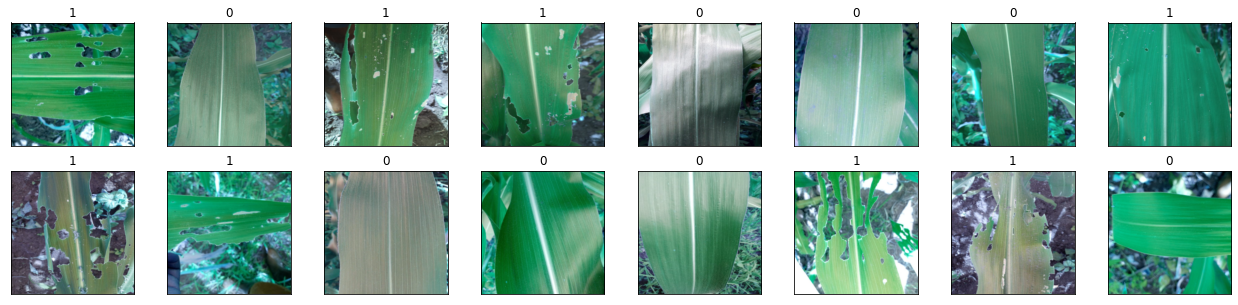

In [ ]:
# without transformation

# obtain a batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images_2, labels_2 = dataiter.next()
Images = torch.cat((images, images_2), 0)
Labels = torch.cat((labels, labels_2), 0)
#images = images.numpy()
print(Images.shape)


# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(22, 5)) # 22
for idx in np.arange(len(Images)):
    ax = fig.add_subplot(2, BATCH_SIZE, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(Images[idx], (1,2,0)))
    ax.set_title(str(Labels[idx].item()))

## 3. Model design
### Area of ML
Since we have a labeled dataset and aim to provide a classification model trained on this labebed dataset, we are solving `supervised leaning problem`  

### Architecture and motivation
Since we want to do classificication based on image data, the more efficient architecture for a such task is a `Convolutional Neural Network (CNN)`. Indeed, CNN is a type of artificial neural network used in image recognition and processing that is specifically designed to process pixel data. At the highest level, CNNs take images as inputs and return probabilities that the image belongs to each of the possible classes.

In slightly more detail, CNNs hierarchically extract features from images using convolutional layers, which are usually followed by pooling layers that summarise the information in the extracted feature maps:

### Transfert learning
Transfert learning is a ML method that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem [4]. Intuitively, instead of training our model on our task from scratch, we first identify a model that has been pre-trained on some other image task and then adapt it (**"fine-tune"** it) to our specific task.

Transfert learning is a popular approach in ML community because it often gets two mains advantages:
- **Improved performance**. The pre-training does a lot of the heavy lifting of learning to understand images since the most popular pre-trained models were trained on huge datasets for a long period of time, and we can simply piggy back on what they've learned.
- **Lower data and computational requirements**. Using a pre-trained model often means we don't need as much training data, time, or compute to reach a certain level of performance.

There are plenty of pre-trained computer vision models available, the most popular probably being VGG, ResNet, EfficientNet, etc. In this work I will use `ResNet-50`

In this case, we use the ResNet-50 where we fine-tuine the classification layer on our

[4] https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjvqPGz3ez3AhVmRvEDHQwPBM0QFnoECBkQAw&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FTransfer_learning&usg=AOvVaw2HhdpOpHnaIlHbqcB21o43

In [ ]:
model = models.resnet50(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 2)

#dtime = datetime.now().strftime('%d-%m-%Y_%H:%M:%S')
model_path = "Makerere_Fall_Armyworm_Crop_Challenge/model_store"
#os.makedirs(model_path)
#best_model = os.path.join(model_path, dtime, 'best_model.pth')
best_model = "Makerere_Fall_Armyworm_Crop_Challenge/model_store/best_model.pth"

## 4. Model training
### Method
- training hadware: GPU
- epochs: 20
- stopping conditions: after each epoch, the model is evaluate on the validation dataset and the model with the best accuracy value is saved for the test step

### Strategy for hyperparameter
- ADAM optimizer
- learning rate = 0.001
- no learning rate scheduler

In [ ]:
epochs = 20
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

#device = 'cpu'
model = model.to(device)

In [ ]:
model.train()

start = time.time()
best_indicator = 0

train_loss, train_acc = [], []
val_loss, val_acc = [], []
train_auc, val_auc = [], []
for epoch in range(1, epochs + 1):
    epoch_train_loss, epoch_train_accuracy = 0, 0
    y_probs = np.zeros((0, 2), np.float32)
    y_trues = np.zeros((0), np.int32)

    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # model.forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        #train_loss_ = epoch_train_loss / (step + 1)

        probs = F.softmax(outputs, dim=1)
        y_probs = np.concatenate([y_probs, probs.detach().cpu().numpy()])
        y_trues = np.concatenate([y_trues, labels.cpu().numpy()])

        _, preds = probs.topk(1, dim=1)

        equals = preds == labels.view(*preds.shape)
        epoch_train_accuracy += equals.sum().item()


    fpr, tpr, _ = roc_curve(y_trues, y_probs[:, 1])
    binary_auc = auc(fpr, tpr)
    train_auc.append(binary_auc)

    train_loss_ = epoch_train_loss / (len(train_loader))
    train_loss.append(train_loss_)

    train_acc_ = epoch_train_accuracy / (inputs.shape[0] * len(train_loader))
    train_acc.append(train_acc_)

    with torch.no_grad():
        running_val_loss = 0
        running_val_accuracy = 0
        for step, (inputs, labels) in enumerate(val_loader):
            model.eval()
            inputs, labels = inputs.to(device), labels.to(device)

            # model.forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()


            probs = F.softmax(outputs, dim=1)
            y_probs = np.concatenate([y_probs, probs.detach().cpu().numpy()])
            y_trues = np.concatenate([y_trues, labels.cpu().numpy()])

            probs_val, preds = probs.topk(1, dim=1)
            equals = preds == labels.view(*preds.shape)
            running_val_accuracy += equals.sum().item()

        fpr, tpr, _ = roc_curve(y_trues, y_probs[:, 1])
        binary_val_auc = auc(fpr, tpr)
        val_auc.append(binary_val_auc)

        val_loss_ = running_val_loss / len(val_loader)
        val_loss.append(val_loss_)

        val_acc_ = running_val_accuracy / (inputs.shape[0] * len(val_loader))
        val_acc.append(val_acc_)

        model.train()

        print("Epoch {}/{} ".format(epoch, epochs),
              "Training Loss: {:.3f} ".format(train_loss_),
              "Training Accuracy: {:.3f} ".format(train_acc_),
              "Training AUC: {:.3f} ".format(binary_auc),
             "Validation Loss: {:.3f} ".format(val_loss_),
             "Validation Accuracy: {:.3f} ".format(val_acc_),
              "Validation AUC: {:.3f} ".format(binary_val_auc),
             )

        if val_acc[-1] > best_indicator:
            print('save best model epoch {} accuracy {}'.format(epoch, best_indicator) )
            best_indicator = val_acc[-1]
            torch.save(model.state_dict(), best_model)

metrics = pd.DataFrame({
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_loss': val_loss,
                'train_auc': train_auc,
                'val_auc': val_auc})


metrics.to_csv("Makerere_Fall_Armyworm_Crop_Challenge/model_store/metrics.csv")

end = time.time()

Epoch 1/20  Training Loss: 0.422  Training Accuracy: 0.838  Training AUC: 0.911  Validation Loss: 0.114  Validation Accuracy: 0.969  Validation AUC: 0.924 
save best model epoch 1 accuracy 0
Epoch 2/20  Training Loss: 0.232  Training Accuracy: 0.915  Training AUC: 0.969  Validation Loss: 0.675  Validation Accuracy: 0.838  Validation AUC: 0.961 
Epoch 3/20  Training Loss: 0.178  Training Accuracy: 0.939  Training AUC: 0.980  Validation Loss: 0.078  Validation Accuracy: 0.981  Validation AUC: 0.982 
save best model epoch 3 accuracy 0.96875
Epoch 4/20  Training Loss: 0.139  Training Accuracy: 0.945  Training AUC: 0.988  Validation Loss: 0.060  Validation Accuracy: 0.981  Validation AUC: 0.989 
Epoch 5/20  Training Loss: 0.189  Training Accuracy: 0.921  Training AUC: 0.978  Validation Loss: 0.187  Validation Accuracy: 0.925  Validation AUC: 0.978 
Epoch 6/20  Training Loss: 0.096  Training Accuracy: 0.969  Training AUC: 0.994  Validation Loss: 0.075  Validation Accuracy: 0.969  Validation 

### Progress visualization

[]

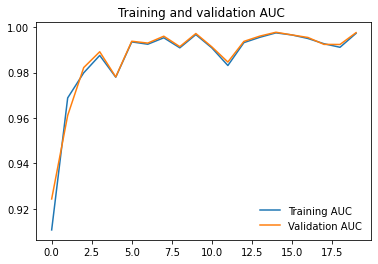

In [ ]:
plt.title("Training and validation AUC ")
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(frameon=False)
plt.plot()

[]

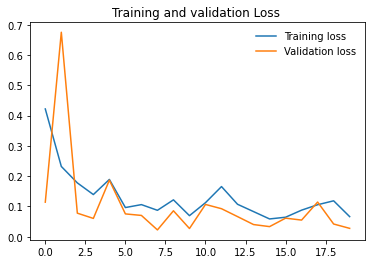

In [ ]:
plt.title("Training and validation Loss ")
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)
plt.plot()

[]

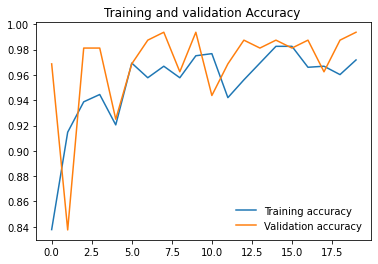

In [ ]:
plt.title("Training and validation Accuracy ")
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.plot()

## 5. Model evaluation
### Illustration and/or summarisation of model predictions on test set

In [ ]:
checkpoint = os.path.join(model_path, 'best_model.pth')
weights = torch.load(checkpoint)
model.load_state_dict(weights, strict=True)

<All keys matched successfully>

In [ ]:
test_loss, test_auc= [], []
y_probs = np.zeros((0, 2), np.float32)
y_trues = np.zeros((0), np.int32)
y_preds = np.zeros((0), np.int32)
with torch.no_grad():
    loss = 0
    accuracy = 0
    for step, (inputs, labels) in enumerate(test_loader):
        model.eval()
        inputs, labels = inputs.to(device), labels.to(device)

        # model.forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss += loss.item()

        probs = F.softmax(outputs, dim=1)
        y_probs = np.concatenate([y_probs, probs.detach().cpu().numpy()])
        y_trues = np.concatenate([y_trues, labels.cpu().numpy()])

        probs_val, preds = probs.topk(1, dim=1)
        y_preds = np.concatenate([y_preds, preds.cpu().numpy().squeeze()])

        equals = preds == labels.view(*preds.shape)
        accuracy += equals.sum().item()

    fpr, tpr, _ = roc_curve(y_trues, y_probs[:, 1])
    test_auc = auc(fpr, tpr)

    test_accuracy = accuracy / len(test)
    model.train()

In [ ]:
test_auc

0.9939661016949153

In [ ]:
test_accuracy

0.9711934156378601

Text(0, 0.5, 'tpr')

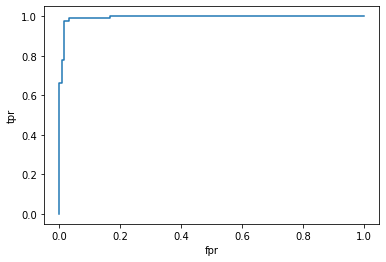

In [ ]:
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')

### Is the model better than random ?
A random model will predict the majority class. In this case the accuracy will be `0.51`. <br>
since our accuracy is `0.9975`, is better than a random model

In [ ]:
(test.Label.value_counts() * 100) / len(test)

0    51.440329
1    48.559671
Name: Label, dtype: float64

### Other evaluation metrics on test set
#### Confusion matrice

In [ ]:
cm = confusion_matrix(y_trues, y_preds)
cm

array([[123,   2],
       [  5, 113]])

In [ ]:
#### Sensitivity
print(classification_report(y_trues, y_preds))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       125
           1       0.98      0.96      0.97       118

    accuracy                           0.97       243
   macro avg       0.97      0.97      0.97       243
weighted avg       0.97      0.97      0.97       243



## 6. Discussion
The initial problem was to build a ML model in order to classify if a plant has been affected by a fall armyworm. To do that, we use a CNN architecture based on ResNet-50 with transfert learning. We also selected a set of hyperparameters like the learning rate, the optimizer, as well as the number of epochs. We saved the best model based on the validation loss.

Our model get on test data an accuracy of `0.9938` which is significantly better than the one we can get with a random model. In addition, the test AUC is `0.97` which is quitte good.

According to these metrics, the model could be deployed in a production environment to help African farmers.

However, from the confusion matrix, we noticed that there are $7$ misclassified images in which we have $2$ `false positives` (the model predicts `1` while the true class is `0`) and $5$ `false negatives` (the model predicts `0` while the true class is `1`). Therefore, it would be useful to plot these misclassified examples to see what they look like in order to try to understand while the model misclassified them.

### 6.1 Misclassified examples

In [ ]:
len(test), len(y_preds)

(243, 243)

In [ ]:
# we add the prediction to the test dataframe
test['preds'] = y_preds
test['proba_1'] = y_probs[:, 1]
test.head()

,Image_id,Label,preds,proba_1
69,id_1qb8dd084lnfr.jpg,1,1,0.990270
1507,id_xhwh238ijn112.jpg,0,0,0.000275
1286,id_t11y5fiwqu3hb.jpg,0,0,0.013467
551,id_c8dimupwht4u0.jpg,1,1,0.999819
836,id_iqf31146kx0ew.jpg,0,0,0.002620


In [ ]:
# misclassified examples
misclassified = test[test.Label != test.preds]
imgs_id = list(misclassified.Image_id)
labels = list(misclassified.Label)
preds = list(misclassified.preds)
print(misclassified.shape)
misclassified

(7, 4)


,Image_id,Label,preds,proba_1
1274,id_stje1bf0orio7.jpg,1,0,0.210933
184,id_48rzpbnfrzlwr.jpg,0,1,0.996689
1305,id_th3emyvy6zfuu.jpg,1,0,0.452420
781,id_hkluz3hzucijh.jpg,1,0,0.233573
974,id_lyd5m8ffmqmcz.jpg,1,0,0.418795
968,id_lr7qsopf3pcev.jpg,1,0,0.018580
128,id_2wogde7nabi75.jpg,0,1,0.980444


In [ ]:
img_path = os.path.join(cfg.base.dir, 'Images')
img_id = misclassified.Image_id.iloc[0]
#print(img_id)

img = mpimg.imread(os.path.join(img_path, img_id))
print(img.shape)

#plt.imshow(img)
#plt.plot()

(1024, 1024, 3)


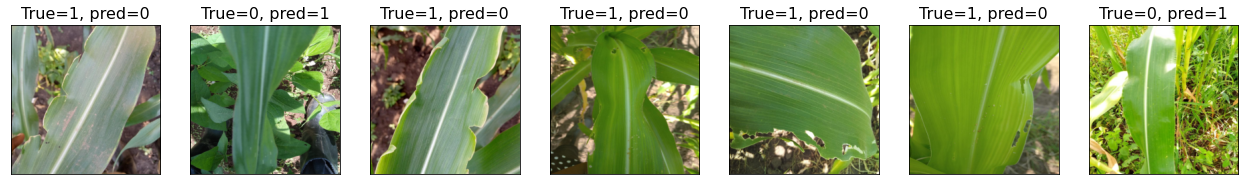

In [ ]:
fig = plt.figure(figsize=(22, 5)) # 22
num_img = len(misclassified)
for idx in range(num_img):
    ax = fig.add_subplot(1, num_img, idx+1, xticks=[], yticks=[])
    img = mpimg.imread(os.path.join(img_path, imgs_id[idx]))
    img = skimage.transform.resize(img, (224, 224))
    ax.imshow(img)
    ax.set_title('True='+str(labels[idx])+', pred='+str(preds[idx]), fontsize=16)

### 6.2 Misclassified examples interpretation
From the above plots we realise that de model seems to be very confuse when there is not enough evidence in the image. For some of them, humain could be confused too

## Saliency map
Neural network models are usually seen as a black box since it is not evident to explain the prediction. In many cases, decision-makers would like to know what the neural network focuses on making predictions. In other words, **what part of the image triggers the decision?**

To answer this question, the `saliency map-based methods` have been proposed where the aim is to highlight the part on the image that has triggered the decision. In the above, we applied the saliency map to our model to highlight the salient part of the infected images

infected dataset size:  118

torch.Size([8, 3, 224, 224])


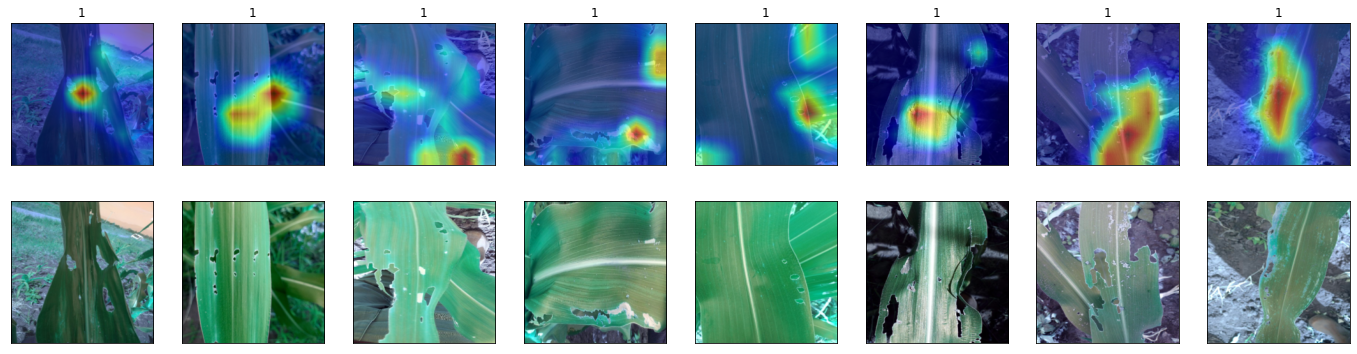

In [ ]:
# dataframe of infected images
infected_csv = os.path.join(dir, 'infected.csv')
infected = pd.read_csv(infected_csv)
infected_dataset = dataset.MakerereDataset(cfg, transform=val_transform, dtype='infected')

print('infected dataset size: ', len(infected_dataset))
print()

infected_loader = DataLoader(infected_dataset,
                          batch_size=8,
                          drop_last=True,
                          num_workers=2,
                          pin_memory=False,
                          shuffle=False)

dataiter = iter(infected_loader)
images, labels = dataiter.next()
#images = images.numpy()

print(images.shape)

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

visualizations = []
originals = []
titles_pred = []
titles_labels = []

# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(24, 6))

for i in range(len(images)):
    img = val_transform(images[i])
    img.unsqueeze_(0)
    img2 = img.numpy().squeeze().transpose((1, 2, 0))
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0, :]
    #print(img2.shape)
    visualization = show_cam_on_image(img2, grayscale_cam, use_rgb=True)
    visualizations.append(visualization)
    originals.append(img2)
    titles_labels.append(labels[i].item())
    #titles_pred.append((yy, p))
    #break

plots = visualizations + originals

num_img = len(plots)
for idx in range(num_img):
    ax = fig.add_subplot(2, num_img//2, idx+1, xticks=[], yticks=[])
    ax.imshow(plots[idx])
    if idx < num_img//2:
        ax.set_title(str(titles_labels[idx]))

plt.show()